In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import os
import numpy as np
import matplotlib.pyplot as plt

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        self.T = nn.Tanh()
        # <создать Wx, Wy?>

    def forward(self, input_data, hidden):
        # <использовать Wx, Wy для полученния нового hidden>
        hidden = self.T(self.W.forward(torch.cat([input_data, hidden], 1)))
        return hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=2

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([2, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
new_hidden:  [[-0.0853065   0.14053988 -0.04945155 -0.04884886  0.00633756]
 [-0.11854563 -0.0412439   0.04434818 -0.42460528 -0.19689617]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[-0.10136566  0.09506332 -0.06576993 -0.02614996 -0.02942809]
 [-0.25852838  0.05397024 -0.01190714 -0.26975474 -0.33085027]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 3 root root 4.0K May 15 16:59 MNIST


Populating the interactive namespace from numpy and matplotlib


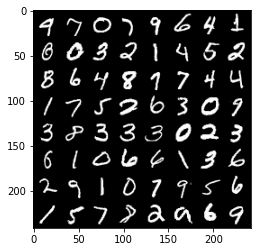

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0715, -0.0823, -0.1113,  0.0569, -0.1277,  0.0478,  0.1243, -0.0209,
         -0.0725, -0.0488],
        [ 0.0605, -0.0908, -0.0940,  0.0644, -0.1125,  0.0573,  0.1662, -0.0233,
         -0.0976, -0.0324],
        [ 0.0640, -0.0693, -0.0731,  0.0511, -0.0939,  0.0480,  0.1518, -0.0239,
         -0.1070, -0.0440],
        [ 0.0593, -0.0758, -0.0916,  0.0574, -0.1020,  0.0446,  0.1644, -0.0230,
         -0.1038, -0.0370],
        [ 0.0424, -0.0941, -0.0694,  0.0529, -0.0964,  0.0472,  0.1550, -0.0412,
         -0.0859, -0.0399],
        [ 0.0554, -0.0713, -0.0771,  0.0524, -0.0940,  0.0507,  0.1515, -0.0265,
         -0.1070, -0.0402],
        [ 0.0691, -0.0790, -0.0874,  0.0674, -0.0977,  0.0448,  0.1726, -0.0172,
         -0.1052, -0.0336],
        [ 0.0607, -0.0701, -0.0723,  0.0463, -0.0973,  0.0512,  0.1564, -0.0232,
         -0.1138, -0.0446],
        [ 0.0714, -0.0852, -0.0828,  0.0425, -0.1071,  0.0601,  0.1569, -0.0280,
         -0.1122, -0.0456],
        [ 0.0637, -

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28, 28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc / i))

Epoch:  0 | Loss: 0.7825 | Train Accuracy: 73.65
Epoch:  1 | Loss: 0.3317 | Train Accuracy: 90.20
Epoch:  2 | Loss: 0.2394 | Train Accuracy: 93.20
Epoch:  3 | Loss: 0.1999 | Train Accuracy: 94.33
Epoch:  4 | Loss: 0.1840 | Train Accuracy: 94.75
Epoch:  5 | Loss: 0.1705 | Train Accuracy: 95.21
Epoch:  6 | Loss: 0.1468 | Train Accuracy: 95.89
Epoch:  7 | Loss: 0.1511 | Train Accuracy: 95.79
Epoch:  8 | Loss: 0.1355 | Train Accuracy: 96.18
Epoch:  9 | Loss: 0.1318 | Train Accuracy: 96.37


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.15


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [ ]:
# это уберет боль работы с текстами
!pip install torchtext==0.11.0

!python -m spacy download en

**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [1]:
import torch
import torchtext
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [2]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:02<00:00, 30.8MB/s]


In [3]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [4]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [5]:
print(vars(train_data.examples[0]))

{'text': ['It', 'is', 'often', 'only', 'after', 'years', 'pass', 'that', 'we', 'can', 'look', 'back', 'and', 'see', 'those', 'stars', 'who', 'are', 'truly', 'stars', '.', 'As', 'that', 'French', 'film', 'critic', ',', 'whose', 'name', 'escapes', 'me', ',', 'said', ':', '"', 'There', 'is', 'no', 'Garbo', '.', 'There', 'is', 'no', 'Dietrich', '.', 'There', 'is', 'only', 'Louise', 'Brooks', '"', ';', 'and', 'there', 'is', ',', 'thank', 'heavens', '!', 'Louise', 'Brooks', '!', 'This', 'is', 'the', 'third', 'of', 'her', 'European', 'masterpieces', '.', 'But', 'it', 'is', 'also', 'an', 'exceptional', 'film', 'for', 'being', 'one', ',', 'if', 'not', 'the', ',', 'first', 'French', 'talkie', ',', 'for', 'following', 'a', 'script', 'written', 'by', 'famed', 'René', 'Clair', ',', 'for', 'reportedly', 'being', 'finished', '(', 'the', 'direction', ',', 'that', 'is', ')', 'by', 'Georg', 'Pabst', ',', 'and', 'for', 'incorporating', 'the', 'voice', 'of', 'Edith', 'Piaf', 'before', 'she', 'was', 'well'

In [6]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [7]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [9]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [10]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 201773), (',', 192526), ('.', 165179), ('a', 109095), ('and', 109013), ('of', 100440), ('to', 93216), ('is', 76366), ('in', 61082), ('I', 53847), ('it', 53489), ('that', 49135), ('"', 44457), ("'s", 43332), ('this', 42034), ('-', 36930), ('/><br', 35349), ('was', 34976), ('as', 30270), ('with', 29764)]


* stoi (string to int)
* itos (int to string)

In [11]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


In [12]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [15]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, batch_size,
                 mode='RNN', bidirectional=False, num_layers=1, dropout=0.0):
        super().__init__()

        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.mode = mode
        self.num_dirs = 2 if bidirectional else 1
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        if mode == 'RNN':
            self.feature_extractor = nn.RNN(embedding_dim, hidden_dim, num_layers,
                                            bidirectional=bidirectional, dropout=dropout)
        elif mode == 'LSTM':
            self.feature_extractor = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                                             bidirectional=bidirectional, dropout=dropout)
        elif mode == 'GRU':
            self.feature_extractor = nn.GRU(embedding_dim, hidden_dim, num_layers,
                                            bidirectional=bidirectional, dropout=dropout)
            
        self.fc = nn.Linear(hidden_dim * num_layers * self.num_dirs, output_dim)
    
    def forward(self, X):
        # text, shape = [sent len, batch size]
        
        embedded = self.embedding(X)
        #embedded.shape = [sent len, batch size, emb dim]

        if self.mode == 'LSTM':
            output, (hidden, cell) = self.feature_extractor(embedded)
            features = torch.cat([x for x in cell], dim=1) 
        else:    
            output, hidden = self.feature_extractor(embedded)
            # output.shape = [sent len, batch size, hid dim * num directions]
            # hidden.shape = [num layers * num directions, batch size, hid dim]

            features = torch.cat([x for x in hidden], dim=1) 
            # features.shape = [batch size, hid dim * num layers * num directions]
        
        return self.fc(features.squeeze(0))

In [16]:
BATCH_SIZE = 64
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 2
NUM_EPOCHS = 15

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

cuda:0


## Training tools

In [18]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [19]:
def train(model, optimizer, lr_scheduler, criterion, num_epochs, data_tr, data_val):
    history = []

    for epoch in range(num_epochs):
        avg_tr_loss = avg_val_loss = 0
        avg_tr_acc = avg_val_acc = 0

        model.train() # training mode
        for data in data_tr:
            # get the inputs
            inputs, labels = data

            # data to device
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), 10e5)
            optimizer.step()

            # update loss and accuracy
            avg_tr_loss += loss.item() / len(data_tr)
            avg_tr_acc += get_accuracy(outputs, labels, BATCH_SIZE) / len(data_tr)

            # free GPU memory
            del inputs, labels, outputs, loss
            torch.cuda.empty_cache()

        model.eval() # testing mode
        with torch.no_grad():
            for data in data_val:
                # get the inputs
                inputs, labels = data

                # data to device
                inputs = inputs.to(device)
                labels = labels.long().to(device)

                # calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # update loss and accuracy
                avg_val_loss += loss.item() / len(data_val)
                avg_val_acc += get_accuracy(outputs, labels, BATCH_SIZE) / len(data_val)

                # free GPU memory
                del inputs, labels, outputs, loss
                torch.cuda.empty_cache()
        
        # record epoch info
        history.append((avg_tr_loss, avg_val_loss, avg_tr_acc, avg_val_acc))

        lr_scheduler.step()

        # show intermediate results
        print('Epoch:  %d/%d | Train loss: %.4f | Train accuracy: %.2f | Val loss: %.4f | Val Accuracy: %.2f' 
                %(epoch + 1, num_epochs, avg_tr_loss, avg_tr_acc, avg_val_loss, avg_val_acc))

    return history

In [20]:
def visualize_histories(histories, legends, title=''):
    colors = ['c', 'm', 'g', 'b', 'y', 'r']
    subtitles = ['Train loss', 'Validation loss',
                 'Train accuracy', 'Validation accuracy']

    fig = plt.figure(figsize=(20, 12))
    fig.suptitle(title, fontsize=16)

    for num_plot in range(4):
        plt.subplot(2, 2, num_plot + 1)
        plt.title(subtitles[num_plot])
        
        for i, history in enumerate(histories):
            data = [x[num_plot] for x in history]
            plt.plot(data, 'go-', C=colors[i], linewidth=2, markersize=5, label=legends[i])

        plt.legend(loc='best')
        plt.xlabel('epochs')
        plt.ylabel('loss' if num_plot <= 1 else 'accuracy')
        plt.grid(True)

    plt.show()

In [36]:
def evaluate_model(model, test_data):
    avg_test_loss = avg_test_acc = 0
    model.eval() # testing mode
    with torch.no_grad():
        for data in test_data:
            # get the inputs
            inputs, labels = data

            # data to device
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            # calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # update loss and accuracy
            avg_test_loss += loss.item() / len(test_data)
            avg_test_acc += get_accuracy(outputs, labels, BATCH_SIZE) / len(test_data)

            # free GPU memory
            del inputs, labels, outputs, loss
            torch.cuda.empty_cache()

    print('Test loss: %.4f | Test accuracy: %.2f' %(avg_test_loss, avg_test_acc))
    #return avg_test_loss, avg_test_acc

## Обучение простых RNN

In [ ]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_unidir_1_layer = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6995 | Train accuracy: 49.82 | Val loss: 0.7054 | Val Accuracy: 51.13
Epoch:  2/15 | Train loss: 0.6942 | Train accuracy: 50.34 | Val loss: 0.7027 | Val Accuracy: 51.48
Epoch:  3/15 | Train loss: 0.6934 | Train accuracy: 49.42 | Val loss: 0.7049 | Val Accuracy: 50.66
Epoch:  4/15 | Train loss: 0.6931 | Train accuracy: 50.24 | Val loss: 0.7015 | Val Accuracy: 49.87
Epoch:  5/15 | Train loss: 0.6921 | Train accuracy: 49.89 | Val loss: 0.7185 | Val Accuracy: 50.81
Epoch:  6/15 | Train loss: 0.6909 | Train accuracy: 50.82 | Val loss: 0.7304 | Val Accuracy: 49.40
Epoch:  7/15 | Train loss: 0.6904 | Train accuracy: 50.28 | Val loss: 0.7240 | Val Accuracy: 50.62
Epoch:  8/15 | Train loss: 0.6914 | Train accuracy: 50.47 | Val loss: 0.7279 | Val Accuracy: 50.28
Epoch:  9/15 | Train loss: 0.6920 | Train accuracy: 50.40 | Val loss: 0.7258 | Val Accuracy: 49.35
Epoch:  10/15 | Train loss: 0.6909 | Train accuracy: 50.19 | Val loss: 0.7403 | Val Accuracy: 50.65
Epoch:  1

In [ ]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE, bidirectional=True, num_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_bidir_1_layer = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6907 | Train accuracy: 54.43 | Val loss: 0.6628 | Val Accuracy: 59.65
Epoch:  2/15 | Train loss: 0.6462 | Train accuracy: 62.51 | Val loss: 0.6585 | Val Accuracy: 60.08
Epoch:  3/15 | Train loss: 0.5954 | Train accuracy: 68.20 | Val loss: 0.6243 | Val Accuracy: 67.84
Epoch:  4/15 | Train loss: 0.5563 | Train accuracy: 70.64 | Val loss: 0.6388 | Val Accuracy: 64.17
Epoch:  5/15 | Train loss: 0.5559 | Train accuracy: 70.40 | Val loss: 0.6497 | Val Accuracy: 65.25
Epoch:  6/15 | Train loss: 0.4620 | Train accuracy: 78.83 | Val loss: 0.6620 | Val Accuracy: 65.51
Epoch:  7/15 | Train loss: 0.4038 | Train accuracy: 82.06 | Val loss: 0.6253 | Val Accuracy: 73.56
Epoch:  8/15 | Train loss: 0.4466 | Train accuracy: 78.84 | Val loss: 0.6619 | Val Accuracy: 70.31
Epoch:  9/15 | Train loss: 0.5583 | Train accuracy: 70.99 | Val loss: 0.8431 | Val Accuracy: 54.00
Epoch:  10/15 | Train loss: 0.5300 | Train accuracy: 72.48 | Val loss: 0.7347 | Val Accuracy: 53.36
Epoch:  1

In [ ]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE, bidirectional=False, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_unidir_2_layers = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6973 | Train accuracy: 49.95 | Val loss: 0.7082 | Val Accuracy: 48.33
Epoch:  2/15 | Train loss: 0.6953 | Train accuracy: 49.94 | Val loss: 0.7024 | Val Accuracy: 49.46
Epoch:  3/15 | Train loss: 0.6982 | Train accuracy: 50.32 | Val loss: 0.7042 | Val Accuracy: 49.23
Epoch:  4/15 | Train loss: 0.6933 | Train accuracy: 50.47 | Val loss: 0.7084 | Val Accuracy: 49.10
Epoch:  5/15 | Train loss: 0.6942 | Train accuracy: 50.22 | Val loss: 0.7079 | Val Accuracy: 50.48
Epoch:  6/15 | Train loss: 0.6945 | Train accuracy: 50.63 | Val loss: 0.7191 | Val Accuracy: 50.37
Epoch:  7/15 | Train loss: 0.6926 | Train accuracy: 50.35 | Val loss: 0.7243 | Val Accuracy: 49.88
Epoch:  8/15 | Train loss: 0.6978 | Train accuracy: 50.62 | Val loss: 0.7156 | Val Accuracy: 49.75
Epoch:  9/15 | Train loss: 0.6946 | Train accuracy: 50.47 | Val loss: 0.7290 | Val Accuracy: 50.15
Epoch:  10/15 | Train loss: 0.6915 | Train accuracy: 50.75 | Val loss: 0.7430 | Val Accuracy: 49.40
Epoch:  1

In [ ]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE, bidirectional=True, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_bidir_2_layers = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6976 | Train accuracy: 53.70 | Val loss: 0.6806 | Val Accuracy: 55.47
Epoch:  2/15 | Train loss: 0.6633 | Train accuracy: 60.05 | Val loss: 0.7626 | Val Accuracy: 56.87
Epoch:  3/15 | Train loss: 0.6191 | Train accuracy: 65.82 | Val loss: 0.6848 | Val Accuracy: 57.08
Epoch:  4/15 | Train loss: 0.6009 | Train accuracy: 67.07 | Val loss: 0.6911 | Val Accuracy: 58.02
Epoch:  5/15 | Train loss: 0.5645 | Train accuracy: 70.57 | Val loss: 0.6485 | Val Accuracy: 64.94
Epoch:  6/15 | Train loss: 0.4984 | Train accuracy: 75.82 | Val loss: 0.6811 | Val Accuracy: 66.14
Epoch:  7/15 | Train loss: 0.4215 | Train accuracy: 81.07 | Val loss: 0.6285 | Val Accuracy: 71.45
Epoch:  8/15 | Train loss: 0.3588 | Train accuracy: 84.45 | Val loss: 0.6571 | Val Accuracy: 70.38
Epoch:  9/15 | Train loss: 0.3042 | Train accuracy: 87.43 | Val loss: 0.7149 | Val Accuracy: 71.11
Epoch:  10/15 | Train loss: 0.2385 | Train accuracy: 90.81 | Val loss: 0.7671 | Val Accuracy: 71.48
Epoch:  1

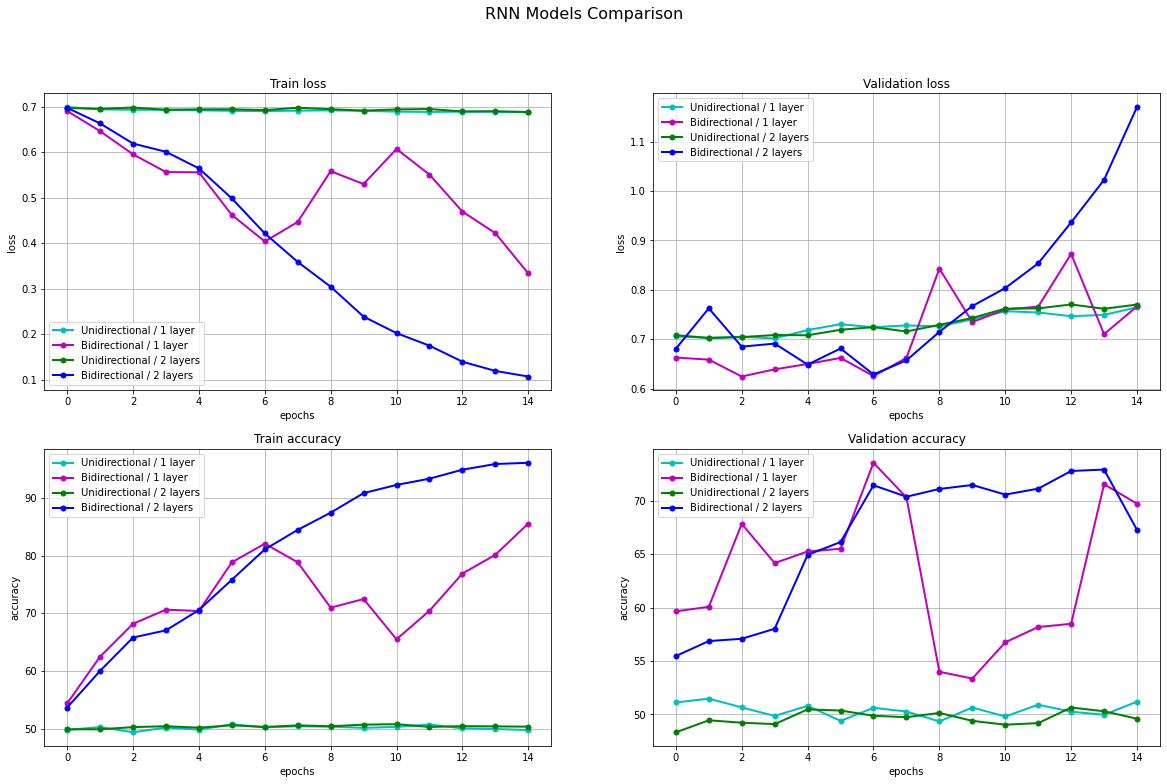

In [ ]:
visualize_histories([history_unidir_1_layer, history_bidir_1_layer, history_unidir_2_layers, history_bidir_2_layers],
                    ['Unidirectional / 1 layer', 'Bidirectional / 1 layer', 'Unidirectional / 2 layers', 'Bidirectional / 2 layers'],
                    title='RNN Models Comparison')

#### Видим, что двунаправенность даёт намного больший прирост в качестве, чем увеличение слоёв RNN, при этом два слоя при bidirectional всё же чуть лучше, чем 1.

#### Попробуем теперь обучить другие архитектуры.

## Обучение LSTM и GRU

In [ ]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE, mode='LSTM', bidirectional=True, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_lstm_bidir_2_layers = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6602 | Train accuracy: 59.36 | Val loss: 0.5994 | Val Accuracy: 66.58
Epoch:  2/15 | Train loss: 0.5672 | Train accuracy: 71.36 | Val loss: 0.5910 | Val Accuracy: 67.92
Epoch:  3/15 | Train loss: 0.5018 | Train accuracy: 75.80 | Val loss: 0.5246 | Val Accuracy: 77.22
Epoch:  4/15 | Train loss: 0.3905 | Train accuracy: 83.23 | Val loss: 0.4526 | Val Accuracy: 79.98
Epoch:  5/15 | Train loss: 0.3210 | Train accuracy: 87.00 | Val loss: 0.5097 | Val Accuracy: 76.40
Epoch:  6/15 | Train loss: 0.2515 | Train accuracy: 90.03 | Val loss: 0.4467 | Val Accuracy: 80.24
Epoch:  7/15 | Train loss: 0.2013 | Train accuracy: 92.38 | Val loss: 0.5119 | Val Accuracy: 82.26
Epoch:  8/15 | Train loss: 0.1384 | Train accuracy: 94.81 | Val loss: 0.6068 | Val Accuracy: 81.48
Epoch:  9/15 | Train loss: 0.1065 | Train accuracy: 96.14 | Val loss: 0.6329 | Val Accuracy: 81.24
Epoch:  10/15 | Train loss: 0.0650 | Train accuracy: 97.58 | Val loss: 0.7648 | Val Accuracy: 80.44
Epoch:  1

In [ ]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE, mode='GRU', bidirectional=True, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_gru_bidir_2_layers = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6708 | Train accuracy: 58.23 | Val loss: 0.6409 | Val Accuracy: 62.41
Epoch:  2/15 | Train loss: 0.4941 | Train accuracy: 75.17 | Val loss: 0.4069 | Val Accuracy: 80.95
Epoch:  3/15 | Train loss: 0.2732 | Train accuracy: 88.71 | Val loss: 0.3441 | Val Accuracy: 84.52
Epoch:  4/15 | Train loss: 0.1745 | Train accuracy: 93.20 | Val loss: 0.3064 | Val Accuracy: 86.80
Epoch:  5/15 | Train loss: 0.1007 | Train accuracy: 96.32 | Val loss: 0.3981 | Val Accuracy: 85.75
Epoch:  6/15 | Train loss: 0.0571 | Train accuracy: 97.84 | Val loss: 0.4450 | Val Accuracy: 85.57
Epoch:  7/15 | Train loss: 0.0242 | Train accuracy: 99.02 | Val loss: 0.5158 | Val Accuracy: 85.39
Epoch:  8/15 | Train loss: 0.0155 | Train accuracy: 99.33 | Val loss: 0.5825 | Val Accuracy: 86.43
Epoch:  9/15 | Train loss: 0.0181 | Train accuracy: 99.16 | Val loss: 0.5738 | Val Accuracy: 86.28
Epoch:  10/15 | Train loss: 0.0128 | Train accuracy: 99.37 | Val loss: 0.5877 | Val Accuracy: 86.31
Epoch:  1

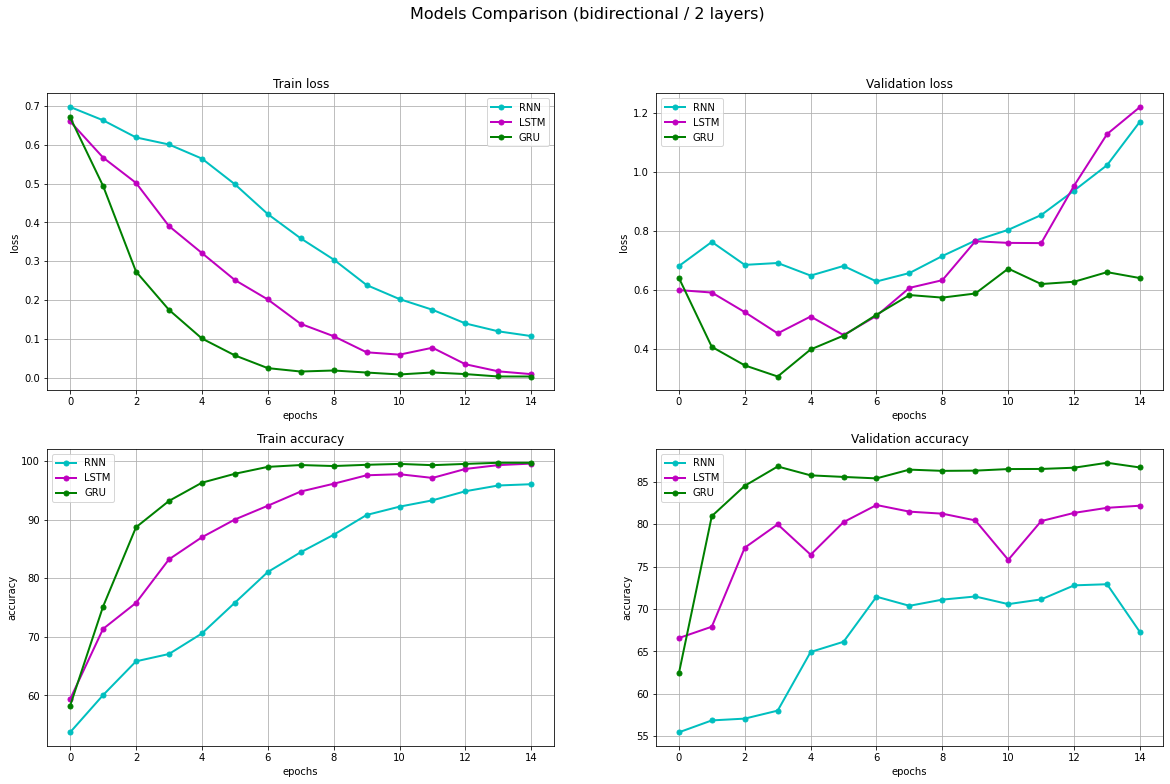

In [ ]:
visualize_histories([history_bidir_2_layers, history_lstm_bidir_2_layers, history_gru_bidir_2_layers],
                    ['RNN', 'LSTM', 'GRU'],
                    title='Models Comparison (bidirectional / 2 layers)')

#### Здесь видим, что GRU при данных параметрах превосходит LSTM, которая, в свою очередь, сильно лучше простой RNN.

#### Также можем видеть, что модели сильно переобучаются, поэтому попробуем дальше обучить GRU с dropout, чтобы хоть чуть-чуть понизить этот эффект.

## Обучение GRU с разными параметрами

In [ ]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE,
            mode='GRU', bidirectional=True, num_layers=3, dropout=0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_gru_3_layers_dropout_30 = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6714 | Train accuracy: 58.11 | Val loss: 0.5522 | Val Accuracy: 71.93
Epoch:  2/15 | Train loss: 0.4182 | Train accuracy: 80.71 | Val loss: 0.3581 | Val Accuracy: 83.32
Epoch:  3/15 | Train loss: 0.2445 | Train accuracy: 89.96 | Val loss: 0.3213 | Val Accuracy: 85.50
Epoch:  4/15 | Train loss: 0.1614 | Train accuracy: 93.67 | Val loss: 0.3263 | Val Accuracy: 86.71
Epoch:  5/15 | Train loss: 0.0983 | Train accuracy: 96.35 | Val loss: 0.3658 | Val Accuracy: 86.55
Epoch:  6/15 | Train loss: 0.0470 | Train accuracy: 98.35 | Val loss: 0.4500 | Val Accuracy: 85.83
Epoch:  7/15 | Train loss: 0.0264 | Train accuracy: 98.96 | Val loss: 0.5076 | Val Accuracy: 86.67
Epoch:  8/15 | Train loss: 0.0177 | Train accuracy: 99.24 | Val loss: 0.5941 | Val Accuracy: 86.49
Epoch:  9/15 | Train loss: 0.0133 | Train accuracy: 99.38 | Val loss: 0.6899 | Val Accuracy: 85.62
Epoch:  10/15 | Train loss: 0.0150 | Train accuracy: 99.28 | Val loss: 0.6231 | Val Accuracy: 85.69
Epoch:  1

In [22]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE,
            mode='GRU', bidirectional=True, num_layers=2, dropout=0.6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_gru_2_layers_dropout_60 = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6687 | Train accuracy: 58.49 | Val loss: 0.6101 | Val Accuracy: 65.84
Epoch:  2/15 | Train loss: 0.4490 | Train accuracy: 79.03 | Val loss: 0.3525 | Val Accuracy: 84.28
Epoch:  3/15 | Train loss: 0.2589 | Train accuracy: 89.42 | Val loss: 0.3164 | Val Accuracy: 85.82
Epoch:  4/15 | Train loss: 0.1716 | Train accuracy: 93.32 | Val loss: 0.3355 | Val Accuracy: 85.70
Epoch:  5/15 | Train loss: 0.1064 | Train accuracy: 96.04 | Val loss: 0.3583 | Val Accuracy: 86.76
Epoch:  6/15 | Train loss: 0.0544 | Train accuracy: 98.15 | Val loss: 0.4190 | Val Accuracy: 86.24
Epoch:  7/15 | Train loss: 0.0317 | Train accuracy: 98.80 | Val loss: 0.4806 | Val Accuracy: 86.11
Epoch:  8/15 | Train loss: 0.0254 | Train accuracy: 99.02 | Val loss: 0.5062 | Val Accuracy: 87.17
Epoch:  9/15 | Train loss: 0.0142 | Train accuracy: 99.37 | Val loss: 0.5382 | Val Accuracy: 87.10
Epoch:  10/15 | Train loss: 0.0119 | Train accuracy: 99.45 | Val loss: 0.6244 | Val Accuracy: 87.38
Epoch:  1

In [26]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE,
            mode='GRU', bidirectional=True, num_layers=3, dropout=0.75).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_gru_3_layers_dropout_75 = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/15 | Train loss: 0.6631 | Train accuracy: 59.23 | Val loss: 0.6294 | Val Accuracy: 64.61
Epoch:  2/15 | Train loss: 0.5427 | Train accuracy: 73.25 | Val loss: 0.5637 | Val Accuracy: 72.13
Epoch:  3/15 | Train loss: 0.4258 | Train accuracy: 81.37 | Val loss: 0.4245 | Val Accuracy: 82.24
Epoch:  4/15 | Train loss: 0.2928 | Train accuracy: 88.10 | Val loss: 0.3555 | Val Accuracy: 85.00
Epoch:  5/15 | Train loss: 0.2032 | Train accuracy: 92.30 | Val loss: 0.3380 | Val Accuracy: 86.60
Epoch:  6/15 | Train loss: 0.1325 | Train accuracy: 95.28 | Val loss: 0.3884 | Val Accuracy: 86.27
Epoch:  7/15 | Train loss: 0.0875 | Train accuracy: 96.83 | Val loss: 0.4616 | Val Accuracy: 86.00
Epoch:  8/15 | Train loss: 0.0553 | Train accuracy: 98.09 | Val loss: 0.5368 | Val Accuracy: 86.47
Epoch:  9/15 | Train loss: 0.0321 | Train accuracy: 98.81 | Val loss: 0.5626 | Val Accuracy: 86.11
Epoch:  10/15 | Train loss: 0.0258 | Train accuracy: 98.93 | Val loss: 0.7193 | Val Accuracy: 85.77
Epoch:  1

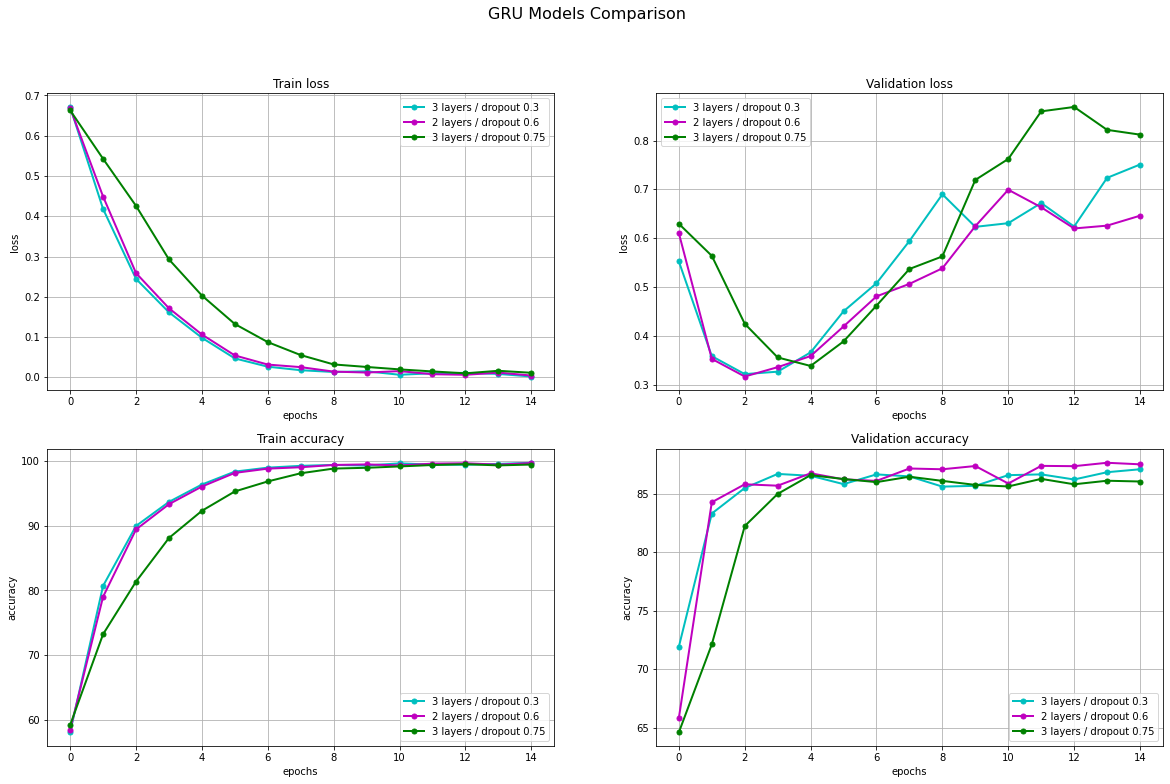

In [34]:
visualize_histories([history_gru_3_layers_dropout_30, history_gru_2_layers_dropout_60, history_gru_3_layers_dropout_75],
                    ['3 layers / dropout 0.3', '2 layers / dropout 0.6', '3 layers / dropout 0.75'],
                    title='GRU Models Comparison')

#### Здесь можем видеть, что добавление ещё одного слоя не особо улучшает модель: только сильнее переобучение, даже с большим dropout'ом. Также видим, что модели начинают переобучаться уже после 2-4 слоя, поэтому долго их обучать смысла тоже нет.

#### Обучим финальную модель и посмотрим на точность на тестовой выборке.

## Финальная модель и оценка качества

In [44]:
NUM_EPOCHS = 5

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE,
            mode='GRU', bidirectional=True, num_layers=2, dropout=0.7).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.9825)
criterion = nn.CrossEntropyLoss()

history_gru_2_layers_dropout_70 = train(model, optimizer, lr_scheduler, criterion, NUM_EPOCHS, train_iterator, valid_iterator)

Epoch:  1/5 | Train loss: 0.6870 | Train accuracy: 55.66 | Val loss: 0.6628 | Val Accuracy: 59.84
Epoch:  2/5 | Train loss: 0.5730 | Train accuracy: 69.38 | Val loss: 0.4553 | Val Accuracy: 78.99
Epoch:  3/5 | Train loss: 0.3425 | Train accuracy: 84.89 | Val loss: 0.3213 | Val Accuracy: 86.10
Epoch:  4/5 | Train loss: 0.2238 | Train accuracy: 90.85 | Val loss: 0.2870 | Val Accuracy: 87.69
Epoch:  5/5 | Train loss: 0.1443 | Train accuracy: 94.57 | Val loss: 0.3270 | Val Accuracy: 86.69


In [45]:
evaluate_model(model, test_iterator)

Test loss: 0.3704 | Test accuracy: 85.23
